In [1]:
import pandas as pd

In [245]:
df = pd.read_csv('car_data.csv')

#### Any empty values or duplicates?

In [246]:
print(f"Number of empty values {df.isna().sum().sum()}")
print(f"Number of duplicate values {df.duplicated().sum()}")

Number of empty values 0
Number of duplicate values 2


#### There are no empty values. But there are 2 duplicated values in our dataset. Let's see them...

In [152]:
df[df.duplicated(keep=False)]

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
15,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0


#### Ok, let us drop duplicated values (to avoid bias in the model)

In [153]:
df.drop_duplicates(keep='first', inplace=True)

#### Let's make sure there are no more duplicates.

In [154]:
print(f"Number of duplicate values {df.duplicated().sum()}")

Number of duplicate values 0


#### Good, now let us do some feature engineering. We will encode the columns with categorical values so they have only numbers.

In [155]:
df.Fuel_Type.nunique(), df.Selling_type.nunique(), df.Transmission.nunique(), df.Car_Name.nunique()

(3, 2, 2, 98)

#### The `Fuel_Type`, `Selling_type`, and `Transmission` columns have `3`, `2` and `2` numbers of unique values respectively, so a simple one-hot encoding would work. The `Car_Name` has `98` unique values, we will target-encode it later. But let's start with the first three that need one-hot encoding.

In [156]:
# one-hot encoding on the 3 cols
df = pd.get_dummies(data=df, columns=['Fuel_Type', 'Selling_type', 'Transmission']) 

In [157]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Owner,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Selling_type_Dealer,Selling_type_Individual,Transmission_Automatic,Transmission_Manual
0,ritz,2014,3.35,5.59,27000,0,False,False,True,True,False,False,True
1,sx4,2013,4.75,9.54,43000,0,False,True,False,True,False,False,True
2,ciaz,2017,7.25,9.85,6900,0,False,False,True,True,False,False,True
3,wagon r,2011,2.85,4.15,5200,0,False,False,True,True,False,False,True
4,swift,2014,4.60,6.87,42450,0,False,True,False,True,False,False,True


#### Great! We have done one-encoding on the 3 cols, now let's do target encoding on the `Car_Name` column.
What exactly is target encoding? Target encoding refers to the encoding of categorical values into numerical ones by grouping the whole dataset by the category, then getting the average of the `target variable`. So, if we were to do that on this very dataset, then we would grouping the whole dataset `(including the future test set)` by the category and getting the mean of the target, that way, the encoded values would be exposed to the test set, which would negatively affect our model. So it's always the best practice to split training and test sets before target encoding.

In [230]:
X = df.drop(columns=['Selling_Price']) # features (independent variables)
y = df.Selling_Price # targets (dependent variables)

In [286]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=pd.qcut(y, 5)) # splitting test vs training sets

In [287]:
from category_encoders import TargetEncoder # get TargetEncoder

target_encoder = TargetEncoder() # initialize encoder
X_train['Car_Name'] = target_encoder.fit_transform(X_train['Car_Name'], y_train) # target encoding in action (training set)
X_test['Car_Name'] = target_encoder.transform(X_test['Car_Name']) # target encoding in action (test set)

#### Before training our model, it's good practice to visualize the relationships between features and the target variable. If the relationships are not linear, a linear regression model may not perform well, and a more complex model might be needed.

C:\Users\Sabon-Kudi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 6400x3200 with 0 Axes>

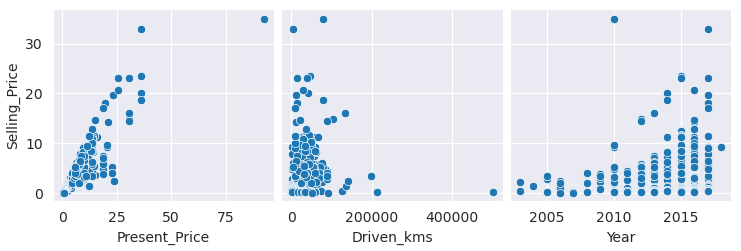

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4), dpi=800)
with sns.axes_style('darkgrid'):
    # sns.jointplot(df, x='Driven_kms', y='Selling_Price')
    sns.pairplot(df, x_vars=['Present_Price', 'Driven_kms', 'Year'], y_vars=['Selling_Price'])
plt.show()

#### There's really no linear relationships between our targets and the 3 main features. But we will go ahead and begin with a linear regression model anyway.

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear = LinearRegression()
linear.fit(X_train, y_train) # training model!

LinearRegression()

In [290]:
pred = linear.predict(X_test) # testing model
mean_absolute_error(y_true=y_test, y_pred=pred)

1.2519664989437185

#### Our linear regression model gave an MAE (mean absolute error) of about 1.29. Let's try something else, we've earlier visually saw that the relationship between the features and targets isn't linear, maybe we should try a random forest model.

In [291]:
from sklearn.ensemble import RandomForestRegressor

random = RandomForestRegressor()
random.fit(X_train, y_train)

pred_rf = random.predict(X_test)
mean_absolute_error(y_true=y_test, y_pred=pred_rf)

1.3391026666666666

#### Our random forest model did even worse! What could be happening? Let's try tweaking the hyperparameters, let's get `RandomizedSearchCV` to get the best hyperparameters for us.

#### Let us try retraining the random forest model with some hyper-parameters.

In [304]:
random = RandomForestRegressor(n_estimators=450, max_depth=7, min_samples_leaf=1, random_state=42)
random.fit(X_train, y_train)

pred_rf = random.predict(X_test)
mean_absolute_error(y_true=y_test, y_pred=pred_rf)

0.7105794361474407

#### Wow, that's an MAE of 0.71, our model is doing reaonably great.